# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




DistilBERT’s 66 million parameters make it 40% smaller and 60% faster than BERT-base, while retaining more than 95% of BERT’s performance

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
!pip install transformers

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sqlalchemy import create_engine
con=create_engine("sqlite:////content/drive/MyDrive/data_folder/database.sqlite")

In [5]:
# using SQLite Table to read data.
#con = sqlite3.connect(/content/database.sqlite) 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
filtered_data['Time'] = filtered_data['Time'].astype(int)

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Sort the final df based on time column inorder to use TimeSeriesSplit
final =final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

## [2.2] Balanced or Imbalanced

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

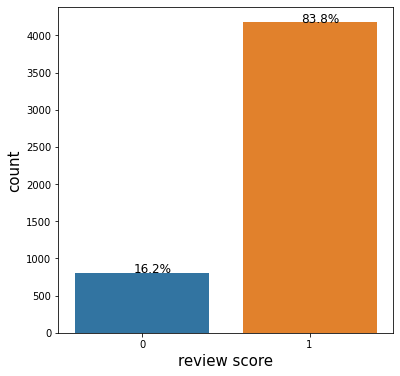

In [19]:
#https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize=(6,6))
ax= sns.countplot(final.Score)
plt.xlabel('review score', size=15);
plt.ylabel('count', size=15);
without_hue(ax, final.Score)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
These are thin,crisp, fragrant cookies and are very delicious and tasty. They are excellent with a glass of cold almond milk or hot herbal tea. (my choices) If you like ginger snaps you will love Lars ginger snaps.
Green Mountain "Nantucket Blend" K-Cups make a very good cup of coffee in my <a href="http://www.amazon.com/gp/product/B000AQPMHA">Keurig B-40 B40 Elite Gourmet Single-Cup Home-Brewing System</a>. This is a very smooth tasting brew that my wife prefers over the <a href="http://www.amazon.com/gp/product/B0029XDZIK">Coffee People, Donut Shop K-Cups for Keurig Brewers (Pack of 50) [Amazon Frustration-Free Packaging</a>] I generally drink in the morning.<br /><br />These are good on both "Small" and "Large" cup settings as well.<br /><br />Highly Recommended!<br /><br />CFH
Besides being smaller than runts, they 

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
These are thin,crisp, fragrant cookies and are very delicious and tasty. They are excellent with a glass of cold almond milk or hot herbal tea. (my choices) If you like ginger snaps you will love Lars ginger snaps.
Green Mountain "Nantucket Blend" K-Cups make a very good cup of coffee in my Keurig B-40 B40 Elite Gourmet Single-Cup Home-Brewing System. This is a very smooth tasting brew that my wife prefers over the Coffee People, Donut Shop K-Cups for Keurig Brewers (Pack of 50) [Amazon Frustration-Free Packaging] I generally drink in the morning.These are good on both "Small" and "Large" cup settings as well.Highly Recommended!CFH
Besides being smaller than runts, they look the same and have the same consistency.  Unfortunately, they taste nothing like banana runts...nor do they even taste good.  Yucky stuff.  Trying t

In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Green Mountain "Nantucket Blend" K-Cups make a very good cup of coffee in my <a href="http://www.amazon.com/gp/product/B000AQPMHA">Keurig B-40 B40 Elite Gourmet Single-Cup Home-Brewing System</a>. This is a very smooth tasting brew that my wife prefers over the <a href="http://www.amazon.com/gp/product/B0029XDZIK">Coffee People, Donut Shop K-Cups for Keurig Brewers (Pack of 50) [Amazon Frustration-Free Packaging</a>] I generally drink in the morning.<br /><br />These are good on both "Small" and "Large" cup settings as well.<br /><br />Highly Recommended!<br /><br />CFH


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Green Mountain Nantucket Blend K Cups make a very good cup of coffee in my a href http www amazon com gp product B000AQPMHA Keurig B 40 B40 Elite Gourmet Single Cup Home Brewing System a This is a very smooth tasting brew that my wife prefers over the a href http www amazon com gp product B0029XDZIK Coffee People Donut Shop K Cups for Keurig Brewers Pack of 50 Amazon Frustration Free Packaging a I generally drink in the morning br br These are good on both Small and Large cup settings as well br br Highly Recommended br br CFH


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text']):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3240.41it/s]


In [29]:
print(preprocessed_reviews[800])
new_df= final.assign(preprocessed_reviews = preprocessed_reviews) 

'hoped would taste like pina coladas not. rather nasty left film tongue. wanted something drink work give kids traveling hard swallow. reason gave stars good mixed drinks. able add smoothies drinks alcohol. going drink straight, helps really cold....almost frozen. really like taste coconut milk might like thing taste it,'

In [81]:
new_df['Score'].shape

(4986,)

## [3.2].  Handle the imbalanced data

**To balance the unbalanced dataset until we reached a 50-50 class distribution we are upsampling the minority class**

In [82]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(new_df['preprocessed_reviews'].values.reshape(-1, 1), new_df['Score'].values.reshape(-1, 1))
y_over.shape

(8356,)

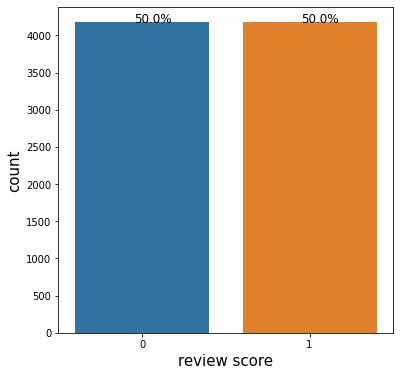

In [135]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize=(6,6))
ax= sns.countplot(y_over)
plt.xlabel('review score', size=15);
plt.ylabel('count', size=15);
without_hue(ax, y_over)

## [3.3].  Split the data to train, cv, test

**Test, Train, split for imbalanced data**

In [30]:
y_label= new_df['Score']
X_label = new_df['preprocessed_reviews']
'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.33, stratify=y_label)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
'''

**Test, Train, split for the balanced data**

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, stratify=y_over)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)


#To convert ndarray to series, which will be passed as input to featurizer
#the X_train returned in the previous step is a ndarray, we convert into pandas series
X_train = pd.Series(X_train.flatten())
y_train = pd.Series(y_train.flatten())
X_cv = pd.Series(X_cv.flatten())
y_cv = pd.Series(y_cv.flatten())
X_test = pd.Series(X_test.flatten())
y_test = pd.Series(y_test.flatten())

# [4] Featurization

## [4.1] Using DistilBertTokenizer

In [98]:
#https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
''' Not used in this project
import tensorflow as tf
train_tensor = tf.data.Dataset.from_tensor_slices((X_train['preprocessed_reviews'].values, y_train.values))
cv_tensor = tf.data.Dataset.from_tensor_slices((X_cv['preprocessed_reviews'].values, y_cv.values))
test_tensor = tf.data.Dataset.from_tensor_slices((X_test['preprocessed_reviews'].values, y_test.values))

for feat, targ in train_tensor.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))
  '''

" Not used in this project\nimport tensorflow as tf\ntrain_tensor = tf.data.Dataset.from_tensor_slices((X_train['preprocessed_reviews'].values, y_train.values))\ncv_tensor = tf.data.Dataset.from_tensor_slices((X_cv['preprocessed_reviews'].values, y_cv.values))\ntest_tensor = tf.data.Dataset.from_tensor_slices((X_test['preprocessed_reviews'].values, y_test.values))\n\nfor feat, targ in train_tensor.take(5):\n  print ('Features: {}, Target: {}'.format(feat, targ))\n  "

###[4.1.1] BERT Tokenizer

In [99]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

# To Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
bert_tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


In [101]:
#We try to tokenize the 1st review text, to check how it works
text=X_train
labels=y_train
print(len(text),len(labels))

bert_tokenizer.tokenize(text[0])

3750 3750


['great',
 'value',
 'like',
 'package',
 'size',
 'not',
 'vinegar',
 '##y',
 'enough',
 'me',
 '.',
 'wo',
 'not',
 'order',
 'brand',
 'again',
 '.',
 'great',
 'chips',
 'otherwise',
 '.']

### [4.1.2] Encode/ decode a text using Bert Tokenizer

In [102]:
bert_inp=bert_tokenizer.encode_plus(text[0],add_special_tokens = True,max_length =64,pad_to_max_length = True,truncation=True)
print(bert_inp)
print("****Attention mask below**")
print(bert_inp['attention_mask'])

bert_tokenizer.decode(bert_inp['input_ids'])


{'input_ids': [101, 2307, 3643, 2066, 7427, 2946, 2025, 29387, 2100, 2438, 2033, 1012, 24185, 2025, 2344, 4435, 2153, 1012, 2307, 11772, 4728, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
****Attention mask below**
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


'[CLS] great value like package size not vinegary enough me. wo not order brand again. great chips otherwise. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

### [4.1.3] Prepare the tenseor for DBert Train, test and cv

In [103]:
#Preparing the input for BERT , we pass text and ylabel as input 
max_len=64
def prepare_inp(input_text, y_label):
  input_ids=[]
  attention_masks=[]
  bert_tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
  for ip in input_text:
      dbert_inps=bert_tokenizer.encode_plus(ip,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
      input_ids.append(dbert_inps['input_ids'])
      attention_masks.append(dbert_inps['attention_mask'])

  input_ids=np.asarray(input_ids)
  attention_masks=np.array(attention_masks)
  labels=np.array(y_label)

  return input_ids,attention_masks,labels


Get the input_ids, Attention mask, labels for train, cv and test and store in pickle file to build the model

In [104]:
train_inp,train_mask,train_label=prepare_inp(X_train,y_train)
cv_inp,cv_mask,cv_label=prepare_inp(X_cv,y_cv)
test_inp,test_mask,test_label=prepare_inp(X_test,y_test)

print('Train inp shape {} , Train label shape {} , Train attention mask shape {} \n'.format(train_inp.shape,train_label.shape,train_mask.shape))
print('cv inp shape {} , cvlabel shape {} , cv attention mask shape {} \n'.format(cv_inp.shape,cv_label.shape,cv_mask.shape))
print('Test inp shape {} , Test label shape {} , Test attention mask shape {} \n'.format(test_inp.shape,test_label.shape,test_mask.shape))

Train inp shape (3750, 64) , Train label shape (3750,) , Train attention mask shape (3750, 64) 

cv inp shape (1848, 64) , cvlabel shape (1848,) , cv attention mask shape (1848, 64) 

Test inp shape (2758, 64) , Test label shape (2758,) , Test attention mask shape (2758, 64) 



## [4.2] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)

cv_final_tf_idf = tf_idf_vect.transform(X_cv['preprocessed_reviews'])
final_tf_idf = tf_idf_vect.transform(X_test['preprocessed_reviews'])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolutely', 'according', 'acid', 'across', 'actual', 'actually', 'add', 'added']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1646, 1487)
the number of unique words including both unigrams and bigrams  1487


# [5] Assignment 3: BERT/ KNN For Sentence/Review Analysis 

<ol>
  <li><strong>Apply DBERT classification on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using DBERT</li>
        </ul>
    </li>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
        </ul>
    </li>
    <br>
    <li><strong>For KNN use the hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>summarize the results at the end of the notebook
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [ ]:
#Roc curve
#https://www.kaggle.com/surentharbe/credit-card-fraud-detection-using-svm-100-auprc
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

## [5.1] DBERT Model

In [105]:
#Unique class labels
max_len=64  #Max sentence length
num_classes = len(y_train.unique())
print(num_classes)

#Defining the loss function we would like to use
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)


def create_bert_model():
    dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Define input layers
    input_ids_layer  = Input(shape = (max_len,),  name='input_ids',  dtype='int64')
    input_attention_layer = Input(shape = (max_len,),  name='input_attention', dtype='int64')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = dbert_model(input_ids_layer, attention_mask=input_attention_layer )[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data
    cls_token = last_hidden_state[:, 0, :]

    dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(cls_token)
    dropout1= Dropout(0.3)(dense)

    dense = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dropout1)
    dropout2= Dropout(0.3)(dense)
    
    # Define a single node that makes up the output layer (for binary classification)
    pred = Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout2)
    
    model = tf.keras.Model(inputs=[input_ids_layer,input_attention_layer], outputs=pred)
    model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
    print(model.summary())
    return model

2


**Callbacks**

In [106]:
log_dir='dbert_model'

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

base_folder = "/content/drive/My Drive/DLProject/BERT_Classification/Weights/"
model_save_path='./dbert_model.h5'


#https://keras.io/api/callbacks/
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=base_folder  + '/seg_' +  
                                                'weights.best.hdf5',save_weights_only=True,
                                                monitor='val_loss',mode='min',save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)]


def display_training_loss_and_accuracy(iteration, history):
    
    title1 = 'model accuracy for iteration :' + str(iteration)
    title2 = 'model loss for iteration :' + str(iteration)
    plt.figure(figsize=(20,4))
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count,history.history['accuracy'])
    plt.plot(epoch_count,history.history['val_accuracy'])
    plt.title(title1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count,history.history['loss'])
    plt.plot(epoch_count,history.history['val_loss'])
    plt.title(title2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### [5.1.1] Training the BERT MODEL

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_8 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 768)          0           tf_distil_bert_model_8[0][0

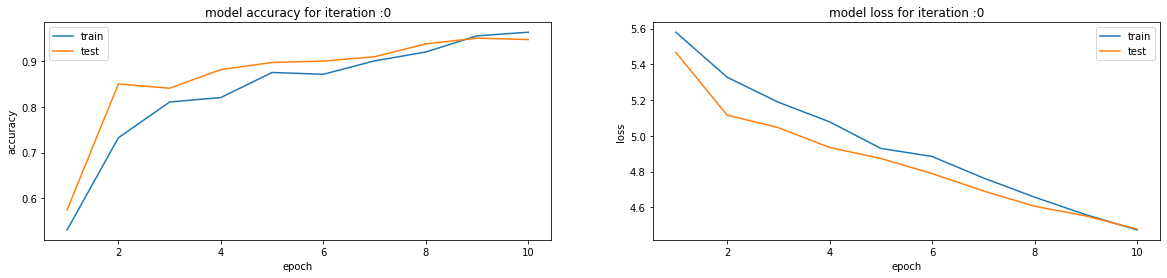

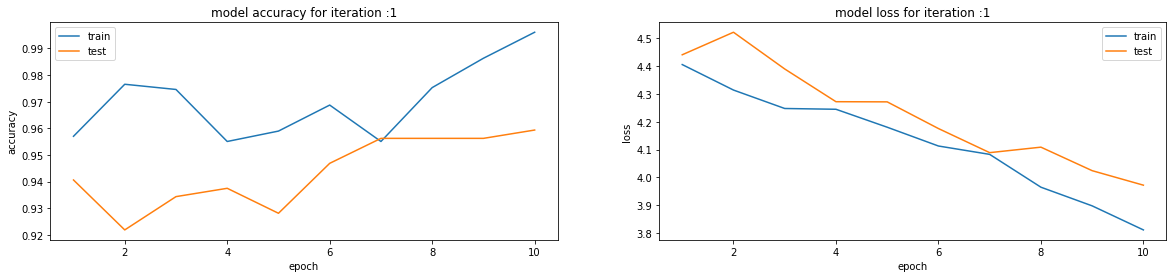

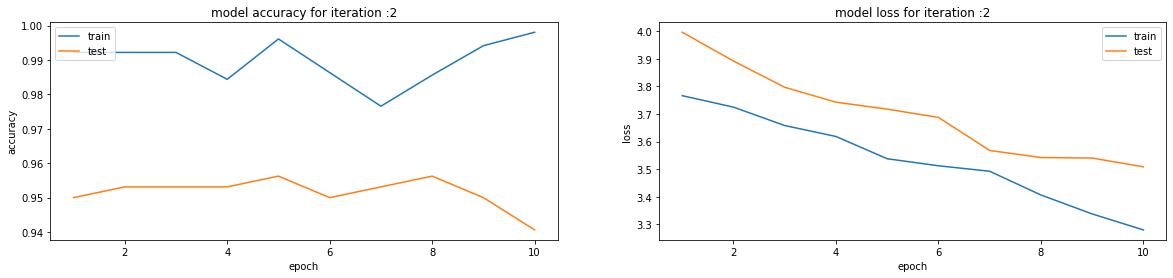

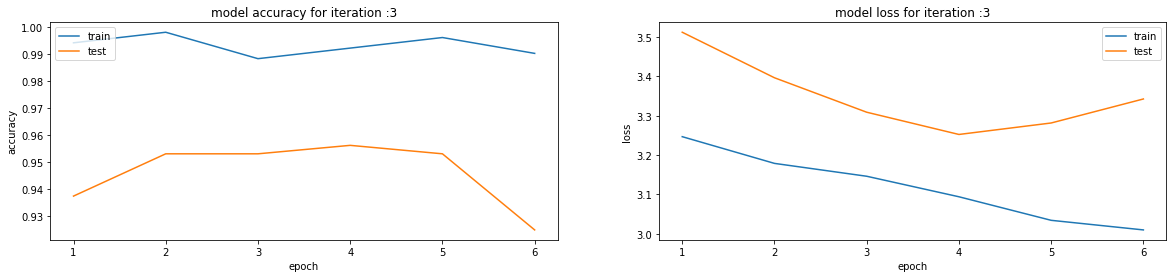

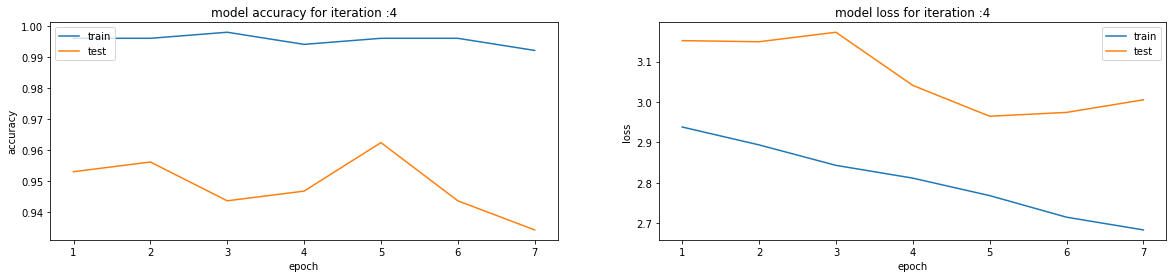

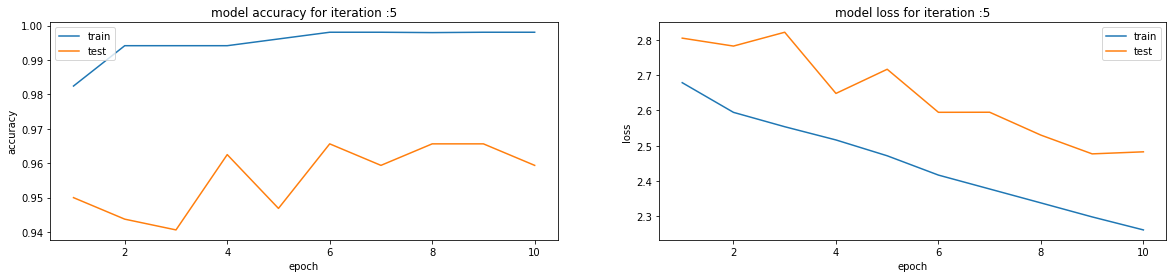

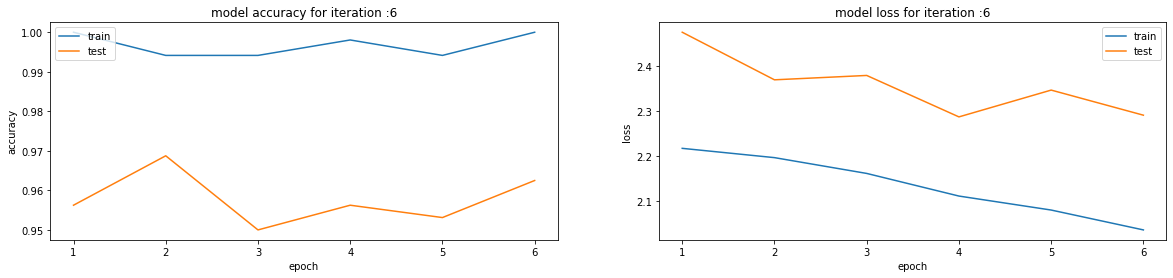

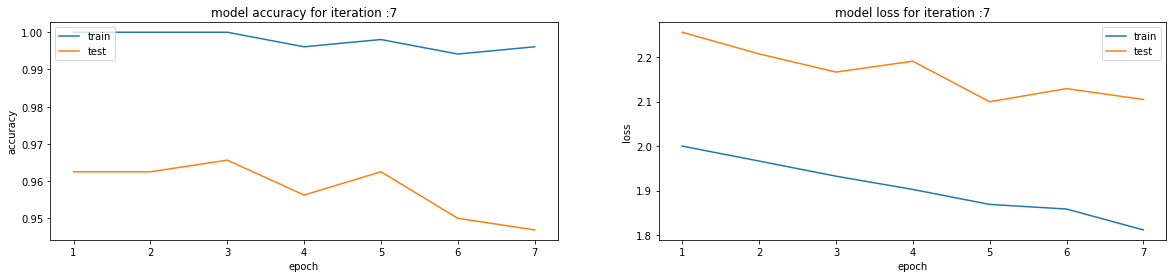

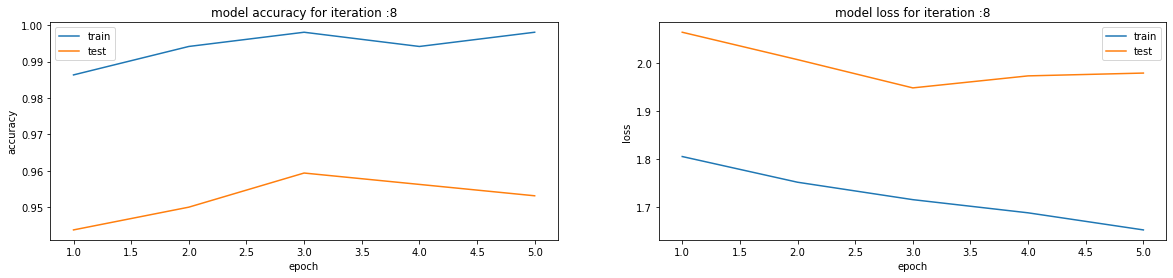

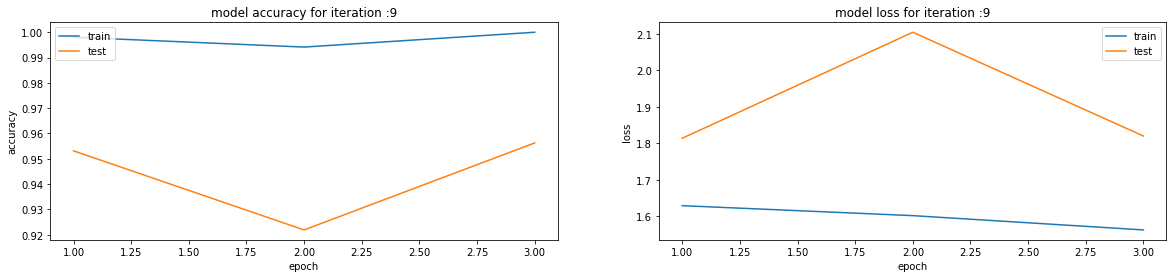

In [107]:
# Hyper parameters
#evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
epochs = 10
stepsforepoch = 16
#n_iter = 20000 # No. of training iterations
n_iter = 10 # No. of training iterations
N_way = 20 # how many persons for testing one-shot tasks
best = -1


def train_bert_model(train_inp,train_mask,train_label,cv_inp,cv_mask,cv_label ):

  model=create_bert_model()
  print("Starting training process!")
  print("-------------------------------------")
  t_start = time.time()
  history_list = []
  for i in range(n_iter):
      print("Iteration # : " , i)
      
      history = model.fit([train_inp,train_mask],train_label, 
                            batch_size=batch_size,
                            steps_per_epoch=stepsforepoch, 
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks, 
                            validation_data=([cv_inp,cv_mask],cv_label),
                            validation_steps=10, 
                            validation_freq=1)
    
      history_list.append(history)
  
  print(history_list[0].history)
  for i in  range(len(history_list)):
      history = history_list[i]
      display_training_loss_and_accuracy(i, history)
  #model=create_bert_model()
  #history=model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=3, validation_data=([cv_inp,cv_mask],cv_label),callbacks=callbacks)
 
train_bert_model(train_inp,train_mask,train_label,cv_inp,cv_mask,cv_label)


### [5.1.2]Test our BERT model on the unseen data**

In [113]:
# Load model weights with trained model weights
model=create_bert_model()
model.load_weights(os.path.join(base_folder, "seg_weights.best.hdf5"))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_11 (TFDist TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_11 (Sl (None, 768)          0           tf_distil_bert_model_11[0]

**Predict and plot F1 score for the test data**

In [139]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

y_pred_keras = model.predict([test_inp,test_mask])
pred_labels = y_pred_keras.argmax(axis=1)

f1 = f1_score(test_label,pred_labels)
print('F1 score',f1)
print()
print('Classification Report')
print(classification_report(test_label,pred_labels,[0,1]))


F1 score 0.9542671948145481

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1379
           1       0.95      0.96      0.95      1379

    accuracy                           0.95      2758
   macro avg       0.95      0.95      0.95      2758
weighted avg       0.95      0.95      0.95      2758



**Plotting confusion matrix for the test data** 

Confusion matrix
[[1306   73]
 [  54 1325]]


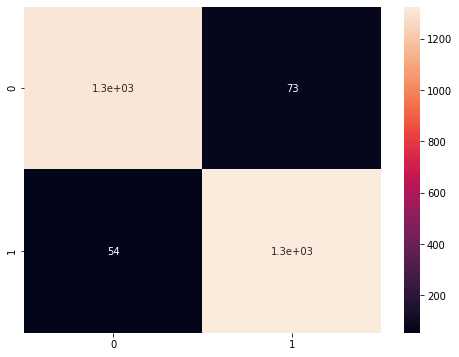

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print('Confusion matrix')
print(confusion_matrix(test_label, pred_labels))

labels = [0, 1]
cm =confusion_matrix(test_label, pred_labels)  
index = [0,1]  
columns = [0,1]  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(8,6))  
sns.heatmap(cm_df, annot=True)


**Plotting AUC for the test data**

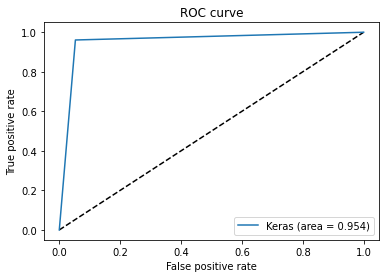

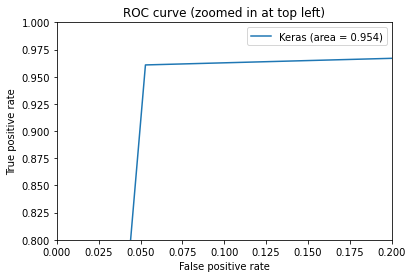

In [132]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label, pred_labels)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


**KNN Model**

In [ ]:
#creating a method for KNN which will be reused by all the algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
def Train_data(X_train,y_train, X_cv, y_cv,algorithm):
    train_auc = []
    cv_auc = []
    K = [1, 5, 10, 15, 21, 31, 41, 51, 61,71, 81, 91]
    for i in K:
        neigh = KNeighborsClassifier(n_neighbors=i, algorithm=algorithm)
        neigh.fit(X_train, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  neigh.predict_proba(X_train)[:,1]
        y_cv_pred =  neigh.predict_proba(X_cv)[:,1]

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    sns.set_style("whitegrid");
    plt.plot(K, train_auc, label='Train AUC')
    plt.scatter(K, train_auc, label='Train AUC')
    plt.plot(K, cv_auc, label='CV AUC')
    plt.scatter(K, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

In [ ]:
def Test_Data(X_train, y_train,X_test,y_test, algorithm,best_k, vectorizer):
    neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm=algorithm)
    neigh.fit(X_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

    sns.set_style("whitegrid");
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    print("="*100)

    table.add_row([vectorizer, algorithm, best_k, str(auc(test_fpr, test_tpr))])
    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(X_test)))

## [5.2] Applying KNN brute force

### [5.2.1] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

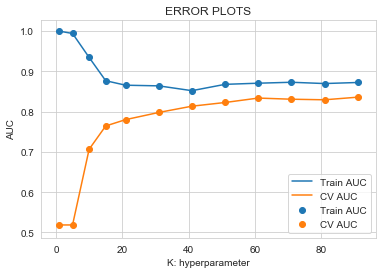

In [ ]:
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Training the Training data to find NN and find best k from CV
Train_data(x_final_tf_idf,y_train,cv_final_tf_idf,y_cv,'brute')

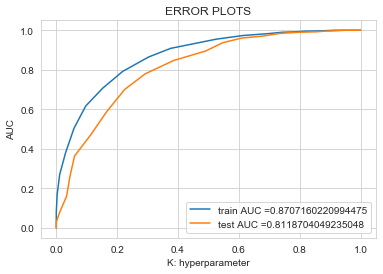

Train confusion matrix
[[   0  362]
 [   0 1875]]
Test confusion matrix
[[   1  266]
 [   0 1379]]


In [ ]:
Test_Data(x_final_tf_idf, y_train, final_tf_idf, y_test,'brute', best_k=61,vectorizer="TFIDF")

## [5.3] Applying KNN kd-tree

### [5.3.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 3</font>

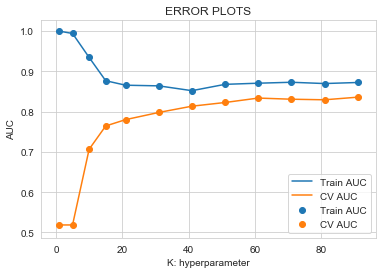

In [ ]:
# Please write all the code with proper documentation
Train_data(x_final_tf_idf,y_train,cv_final_tf_idf,y_cv,'kd_tree')

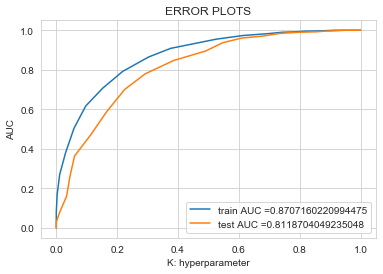

Train confusion matrix
[[   0  362]
 [   0 1875]]
Test confusion matrix
[[   1  266]
 [   0 1379]]


In [ ]:
Test_Data(x_final_tf_idf, y_train, final_tf_idf, y_test,'kd_tree', best_k=61,vectorizer="TFIDF")

# [6] Conclusions

1) We compared the performance of DistilBert and KNN over the Amazon fine food review dataset   
2) We trained our models and tested the performance of our model over unseen test data and plotted the confusion matrix   
3) From the confusion matrix its clear that DistilBert is able to predict with an accuracy score of 95%.   
4) we can further tune the model to achieve a better accuracy.